In [1]:
# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

# Qiskit IBM Provider
from qiskit_ibm_provider import IBMProvider, least_busy

In [2]:
provider = IBMProvider()
backend = least_busy(provider.backends(simulator=False, operational=True))
backend

<IBMBackend('ibm_kyoto')>

In [3]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

circuit = QuantumCircuit(controls, target, mid_measure, final_measure)

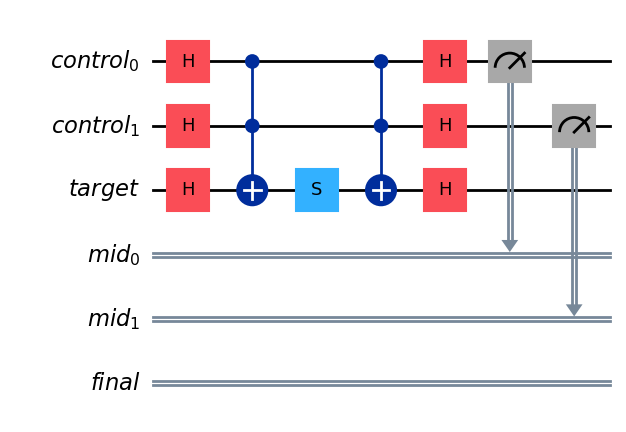

In [4]:
def trial(circuit, target, controls, measures):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)

trial(circuit, target, controls, mid_measure)
circuit.draw(output="mpl", style='iqp', cregbundle=False)

In [5]:
def reset_controls(circuit, controls,  measures):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])

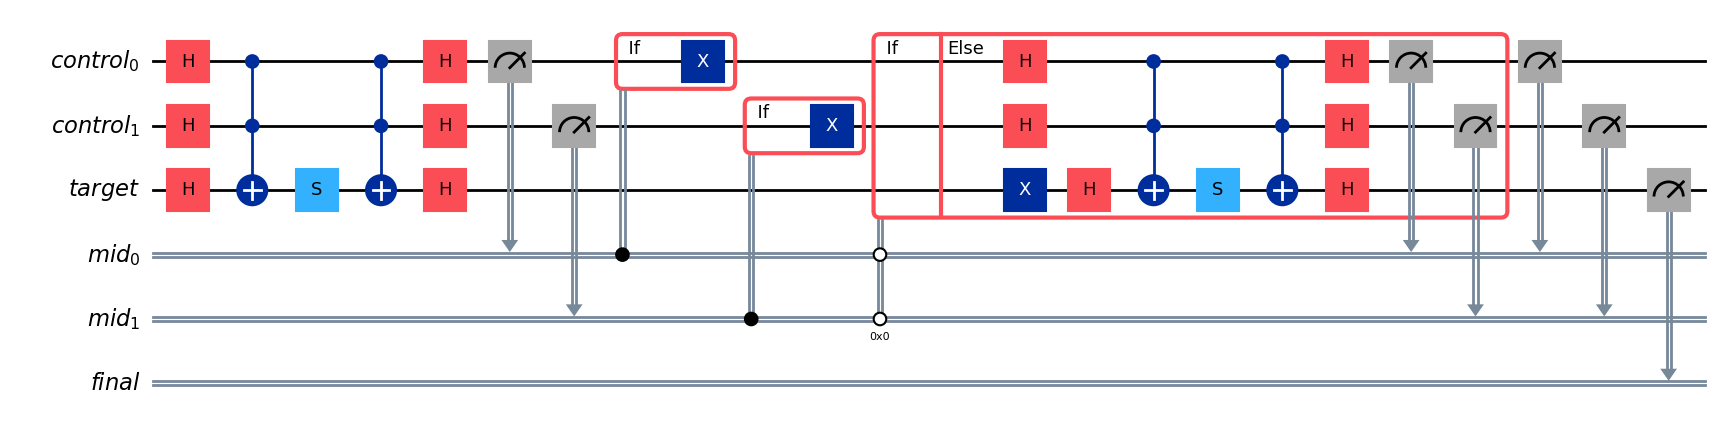

In [6]:
max_trials = 2

# Manually add the rest of the trials.  In the future, we will be
# able to use a dynamic `while` loop to do this, but for now, we
# statically add each loop iteration with a manual condition check
# on each one.  This involves more classical synchronizations than
# the while loop, but will suffice for now.
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        # First reset the target.
        circuit.x(target)
        # Then repeat the trial.
        trial(circuit, target, controls, mid_measure)

# We need to measure the control qubits again to ensure we
# get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're
# getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw(output="mpl", style='iqp', cregbundle=False)

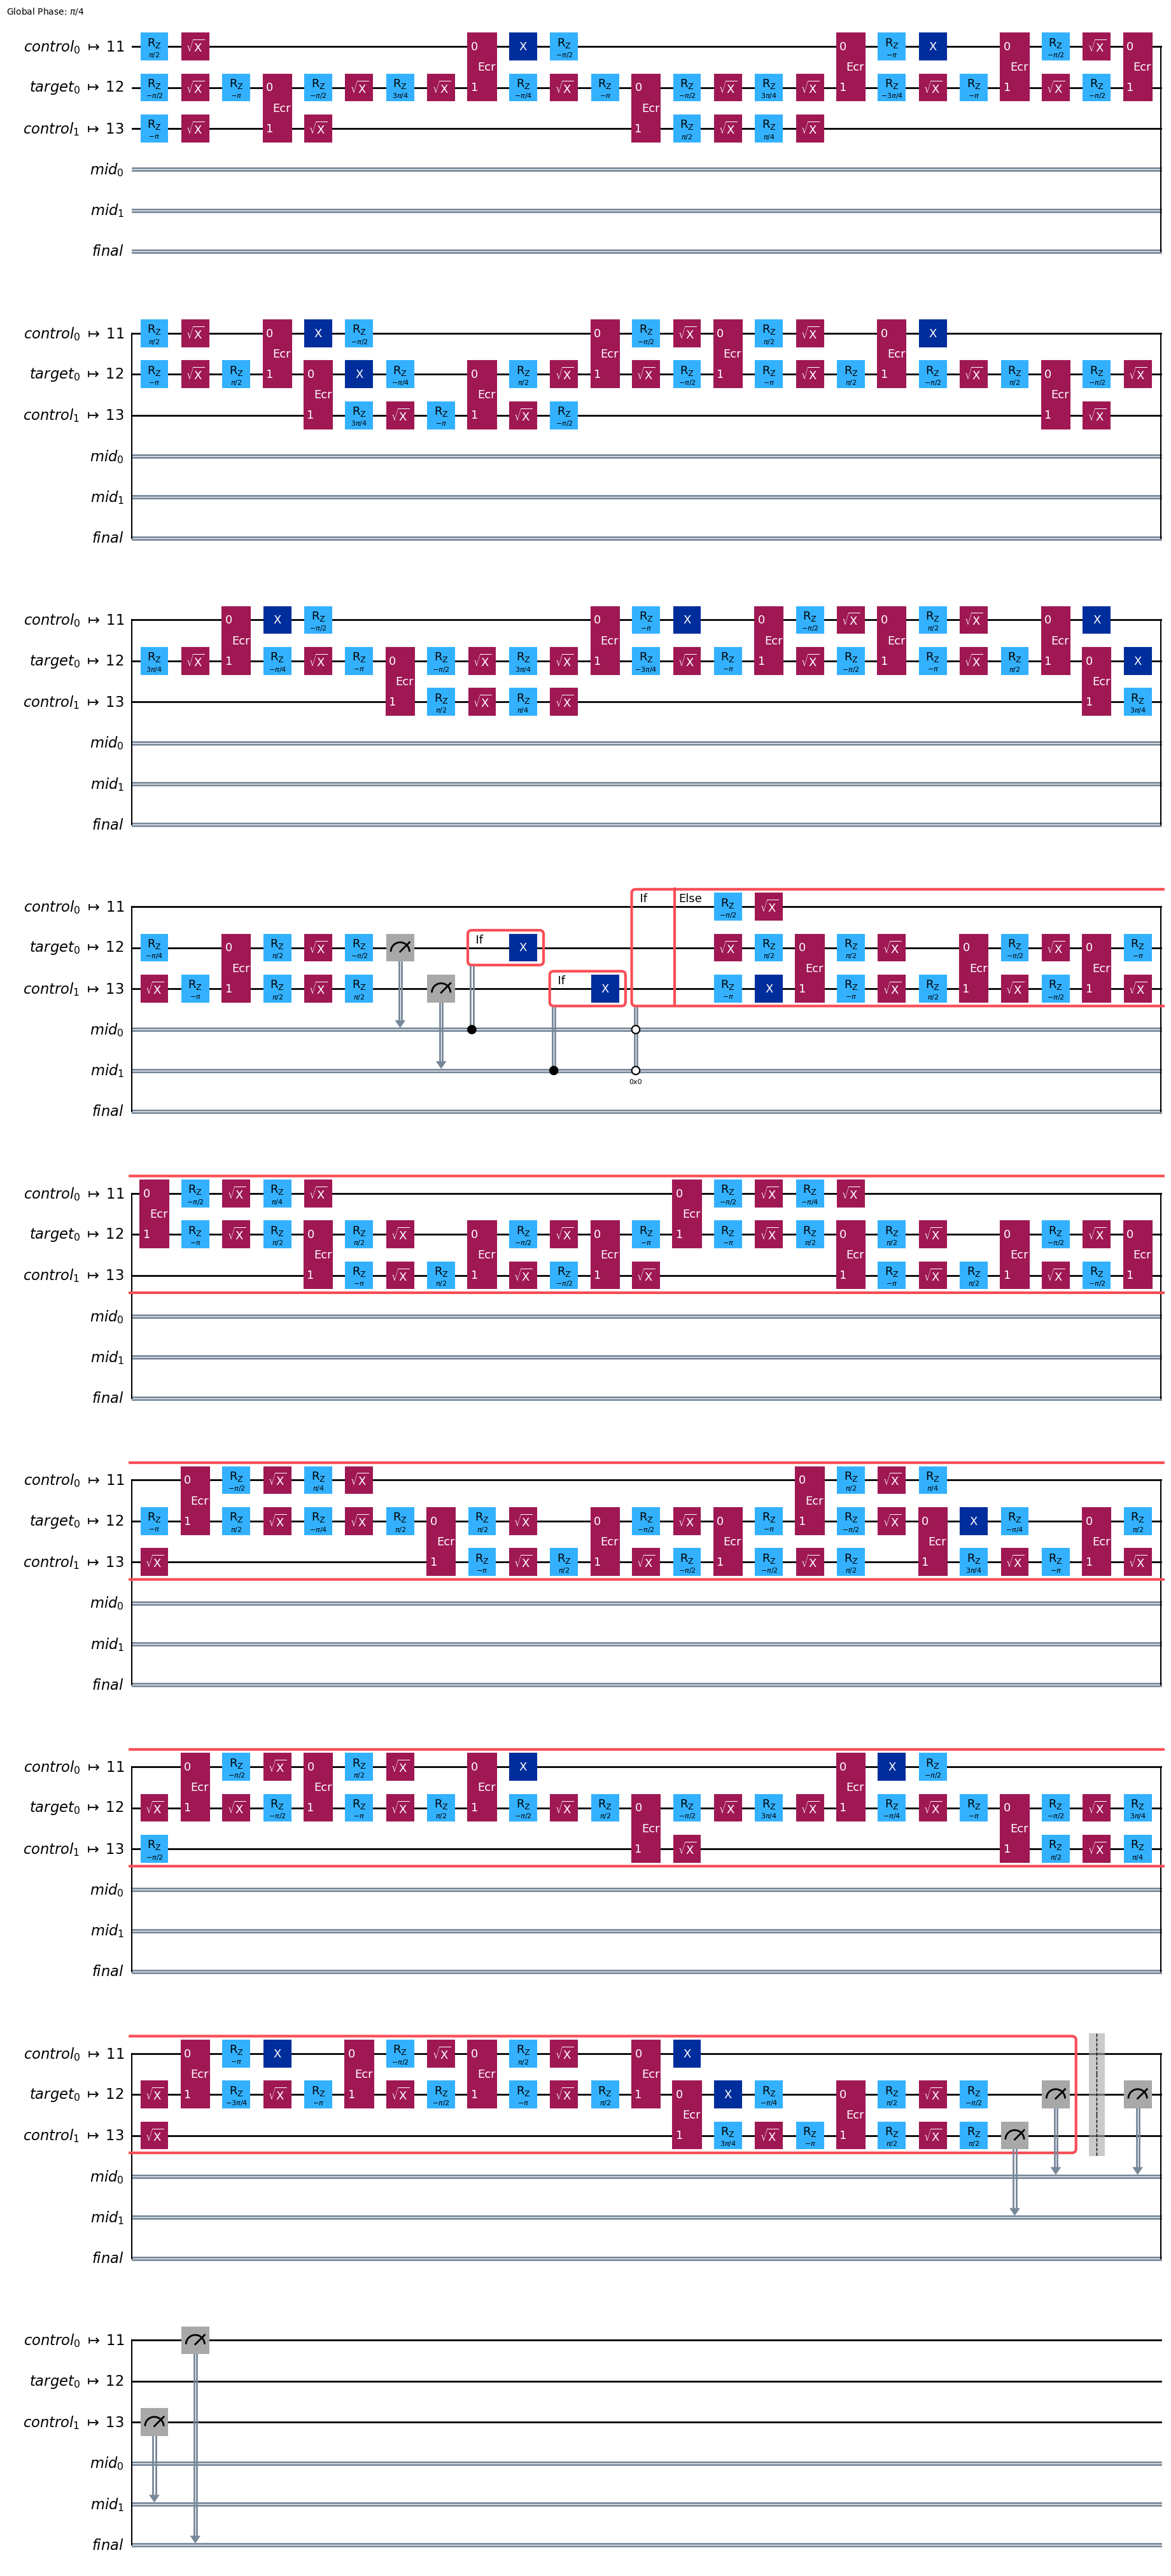

In [7]:
built = transpile(circuit, backend)
built.draw(output="mpl", style='iqp', idle_wires=False, cregbundle=False)

In [10]:
job = backend.run(built, dynamic=True)
job.job_id()

'cqb9q54tzeqg008ssgbg'

In [11]:
hardware_counts = job.result().get_counts()
hardware_counts

In [ ]:
import collections

def marginalize_successes(counts):
    """Split the full output `counts` dictionary
    into two separate dictionaries, marginalizing
    the results to leave only the target qubit's
    state."""
    successes = collections.defaultdict(int)
    failures = collections.defaultdict(int)
    
    for key, value in counts.items():
        if key.endswith("00"):
            successes[key[0]] += value
        else:
            failures[key[0]] += value
            
    return successes, failures

In [ ]:
hw_successes, hw_failures = marginalize_successes(hardware_counts)

expected_successes = 1 - (1 - 5/8)**max_trials
actual_successes = sum(hw_successes.values()) / sum(hardware_counts.values())
print(f"Expected success rate {expected_successes:5.3f}.  Actual rate {actual_successes:5.3f}.")

In [ ]:
actual_probability = hw_successes["1"] / sum(hw_successes.values())
print(f"Expected |1> probability: 0.2.  Actual probability {actual_probability:5.3f}.")